In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
from DL_Autoencoder import DL_auto as DL

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T




# Define your Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [4]:
class Autoencoder2deeper(nn.Module):
    def __init__(self):
        super(Autoencoder2deeper, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim


train_loader, test_loader = DL.create_generators()

Number of files:  38779
2013-10-18_15-48-26_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_15-48-26_01.WAV
Number of files:  5539
2013-10-18_20-03-10_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_20-03-10_01.WAV


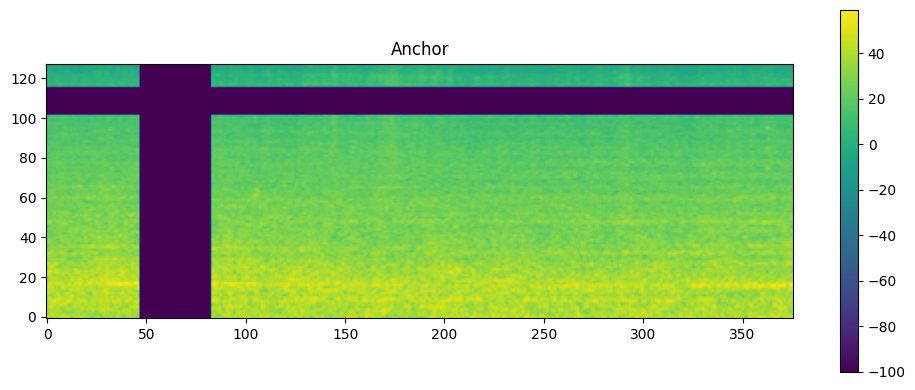

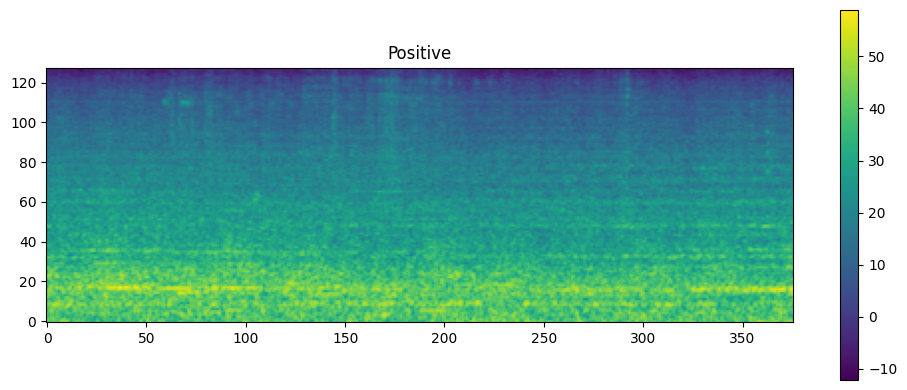

In [6]:
#plot element from train_loader
data1, data2 = next(iter(train_loader))

plt.figure(figsize=(10, 4))
plt.imshow(data1[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Masked Spectrogram')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(data2[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

In [7]:


# Instantiate model, loss function, and optimizer
#model = Autoencoder()
model = Autoencoder2deeper()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    # Wrap your data loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for mel_spec_masked, mel_spec in progress_bar:
        # Move data to device
        mel_spec_masked = mel_spec.to(device)
        mel_spec = mel_spec.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(mel_spec_masked)

        # Compute loss
        loss = criterion(outputs, mel_spec)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update the progress bar
        progress_bar.set_postfix({'train_loss': loss.item()})

    # Compute average loss
    average_train_loss = train_loss / len(train_loader)
    
    # Append the loss for this epoch
    train_losses.append(average_train_loss)

    # Print epoch's average training loss
    print(f'Epoch {epoch+1}, Average Train Loss: {average_train_loss:.4f}')


Epoch 1/50: 100%|██████████| 152/152 [04:48<00:00,  1.90s/it, train_loss=362]


Epoch 1, Average Train Loss: 381.1037


Epoch 2/50: 100%|██████████| 152/152 [04:02<00:00,  1.59s/it, train_loss=370]


Epoch 2, Average Train Loss: 375.0021


Epoch 3/50: 100%|██████████| 152/152 [03:54<00:00,  1.55s/it, train_loss=398]


Epoch 3, Average Train Loss: 373.1941


Epoch 4/50: 100%|██████████| 152/152 [04:07<00:00,  1.63s/it, train_loss=368]


Epoch 4, Average Train Loss: 371.9477


Epoch 5/50:  43%|████▎     | 66/152 [01:33<02:11,  1.53s/it, train_loss=359]

In [ ]:
#save whole model
torch.save(model, './results/res_auto/res_autoen_model.pth')